In [1]:
import numpy as np
import sklearn as sl
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import pandas as pd

# za normalizaciju, standardizaciju
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# rad sa arff fajlovima
#import arff

# graficki prikaz
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# 
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Cross validation attempts to avoid overfitting while still 
# producing a prediction for each observation dataset.
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# Compute precision, recall, F-measure and support
# preciznost, odziv, F-mera, podrska

# ovi podaci se nalaze u sklearn.model_selection

# prognozirani pozitivni/negativni koji su zaista pozitivni od svih prognoziranih pozitivnih/negativnih 
# The precision is the ratio tp / (tp + fp) where tp is the number 
# of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier 
# to not label a sample as positive if it is negative

# odziv
# => prognozirani pozitivni/negativni koji su zaista pozitivni od ukupno pozitivnih/negativnih
# The recall is the ratio tp / (tp + fn) where tp is the number 
# of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0

# The F-beta score weights the recall more than the precision by a factor of beta. 
# beta = 1.0 means recall and precision are equally important

# svi koji pripadaju datoj klasi
# The support is the number of occurrences of each class in y_test

from sklearn.metrics import classification_report

# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# oversampling
from imblearn.over_sampling import SMOTE

from collections import Counter

# feature selection
from sklearn.feature_selection import SelectPercentile, f_classif

In [2]:
from arff2pandas import a2p
    
with open('JM1.arff') as f:
    df = a2p.load(f)

print(df.shape)

(10878, 22)


In [3]:
# uklanjamo instance koje imaju nedostajuce vrednosti
df = df.dropna()
print(df.shape)

(10878, 22)


In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'BRANCH_COUNT@NUMERIC',
       'LOC_CODE_AND_COMMENT@NUMERIC', 'LOC_COMMENTS@NUMERIC',
       'CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC',
       'ESSENTIAL_COMPLEXITY@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [6]:
# df

In [7]:
df = df.drop(columns = ['CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC', 'ESSENTIAL_COMPLEXITY@NUMERIC', 'BRANCH_COUNT@NUMERIC'])

In [8]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'LOC_CODE_AND_COMMENT@NUMERIC',
       'LOC_COMMENTS@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [9]:
# df

In [10]:
df['Defective@{Y,N}'].value_counts()

N    8776
Y    2102
Name: Defective@{Y,N}, dtype: int64

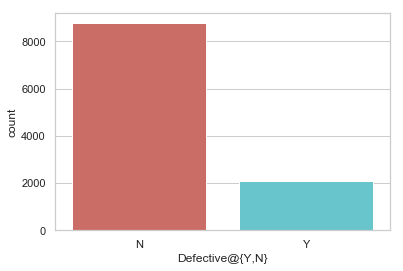

In [11]:
sns.countplot(x='Defective@{Y,N}', data=df, palette='hls')
plt.show()

In [12]:
# Grafik rasporedjenosti instanci po klasama pokazuje da postoji problem neravnomerne raspodele klasa instanci
# Posledica ove neravnomerne raspodele je da ce trenirani model dobro klasifikovati instance klase 'N', a lose
# klasifikovati instance cija je klasa 'Y'. 
# Medjutim, problem je u tome sto su instance od znacaja bas instance klase 'Y'
# Resenje ovog problema je over-sampling - dodavanje novih instanci koje pripadaju manje zastupljenoj klasi 'Y'
# Postoji vise metoda dodavanja novih instanci, a probacemo SMOTE


In [13]:
# kodiramo Y/N u 1/0
df['Defective@{Y,N}'] = pd.factorize(df['Defective@{Y,N}'])[0]

In [14]:
# ciljna kolona(defects@{false, true})
y_cols=['Defective@{Y,N}']

# lista atributa
X_cols=[i for i in df.columns if i not in y_cols]

In [15]:
X=df[X_cols]
y=df[y_cols]

In [16]:
np.set_printoptions(suppress='True')

In [17]:
# potrebno je izvrsiti normalizaciju podataka kako atributi 
# sa visokim vrednostima ne bi previse uticali na rezultat klasifikacije 
X = preprocessing.normalize(X)

In [18]:
# type(X)

In [19]:
# type(X[0])

In [20]:
# X

In [21]:
X[1156]

array([0.00045302, 0.0000755 , 0.00052852, 0.00218959, 0.00183246,
       0.00176149, 0.99748456, 0.00001435, 0.00792782, 0.00000302,
       0.05541547, 0.04274908, 0.00264261, 0.00528521, 0.00135906,
       0.00181207, 0.00339764])

In [22]:
y = y.values.ravel()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [24]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8033088235294118


In [25]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.803705174
standard deviation: 0.013605030


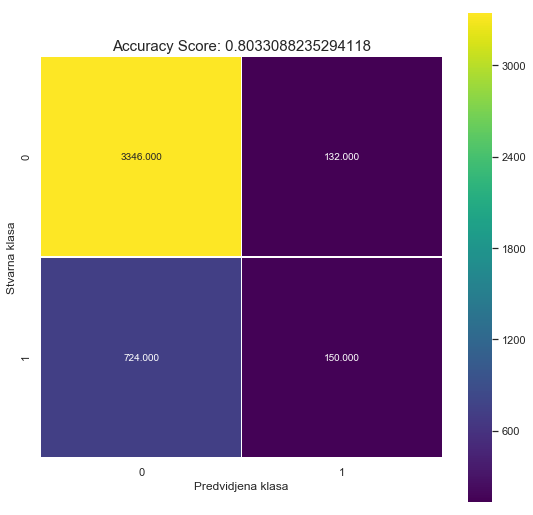

In [26]:
# matrica konfuzije
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_basic_data_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [27]:
# preciznost, odziv, f-mera, podrska
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      3478
           1       0.53      0.17      0.26       874

   micro avg       0.80      0.80      0.80      4352
   macro avg       0.68      0.57      0.57      4352
weighted avg       0.76      0.80      0.76      4352



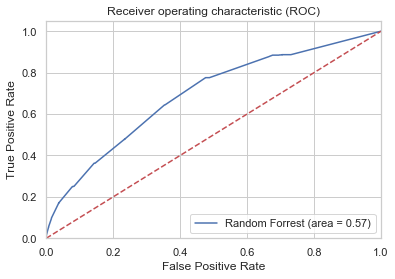

In [28]:
# The receiver operating characteristic (ROC) curve is 
# another common tool used with binary classifiers. 
# The dotted line represents the ROC curve of a purely 
# random classifier; a good classifier stays as far away 
# from that line as possible (toward the top-left corner)

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_basic_data_ROC.png'
plt.savefig(figname)
plt.show()

In [29]:
# oversampling na osnovnim podacima, bez izbora atributa

In [30]:
X_resampled, y_resampled = SMOTE(kind="svm").fit_sample(X, y)

In [31]:
print(sorted(Counter(y_resampled).items()))

[(0, 8776), (1, 8776)]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [33]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8062953995157385


In [34]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.790333122
standard deviation: 0.010653167


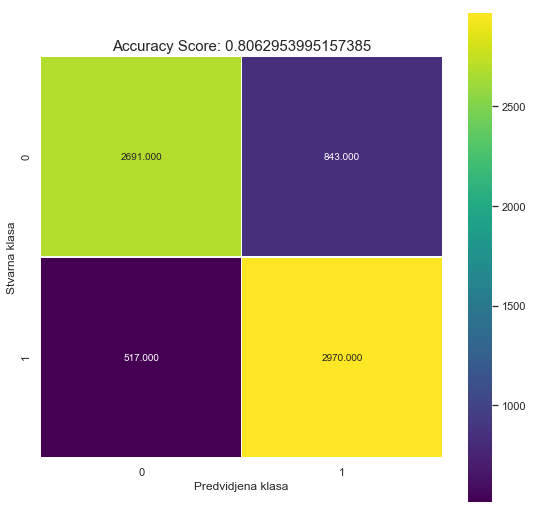

In [35]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      3534
           1       0.78      0.85      0.81      3487

   micro avg       0.81      0.81      0.81      7021
   macro avg       0.81      0.81      0.81      7021
weighted avg       0.81      0.81      0.81      7021



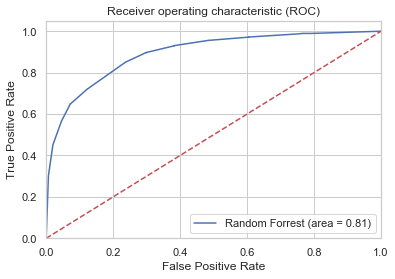

In [37]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [38]:
# pocetak izbora atributa

In [39]:
X_indices = np.arange(X.shape[-1])

In [40]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 60% most significant features
selector = SelectPercentile(f_classif, percentile=60)
selector.fit(X, y)

SelectPercentile(percentile=60,
         score_func=<function f_classif at 0x000001EB805A1D08>)

In [41]:
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

<BarContainer object of 17 artists>

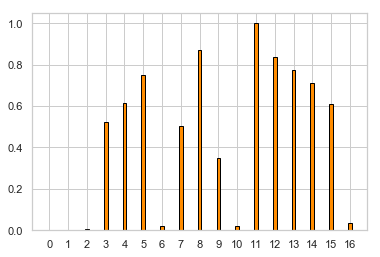

In [42]:
plt.xticks(np.arange(0, len(X_indices)+1, 1.0))
plt.bar(X_indices , scores, width=.2, label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [43]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'LOC_CODE_AND_COMMENT@NUMERIC',
       'LOC_COMMENTS@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [44]:
df.columns[12]

'NUM_OPERANDS@NUMERIC'

In [45]:
scores[11]

1.0

In [46]:
#
scores

array([0.00104463, 0.00208168, 0.00547834, 0.52152631, 0.61425836,
       0.749375  , 0.01989515, 0.50286302, 0.86975329, 0.35091799,
       0.02004311, 1.        , 0.83754271, 0.77586396, 0.71235082,
       0.60772886, 0.0359282 ])

In [47]:
#
np.argpartition(scores, -1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 16, 12, 13, 14, 15, 11],
      dtype=int64)

In [48]:
# df.columns[15]

In [49]:
# df.columns[19]

In [50]:
ind = np.argpartition(scores, -10)[-10:]

In [51]:
df.columns[ind]

Index(['HALSTEAD_ERROR_EST@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'NUM_UNIQUE_OPERATORS@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'NUM_OPERANDS@NUMERIC',
       'NUM_OPERATORS@NUMERIC', 'NUM_UNIQUE_OPERANDS@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC'],
      dtype='object')

In [52]:
X_transformed = selector.transform(X)

In [53]:
# kraj izbora atributa

In [54]:
# izbor atributa bez oversampling-a

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)

In [56]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7973345588235294


In [57]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.805699274
standard deviation: 0.015845585


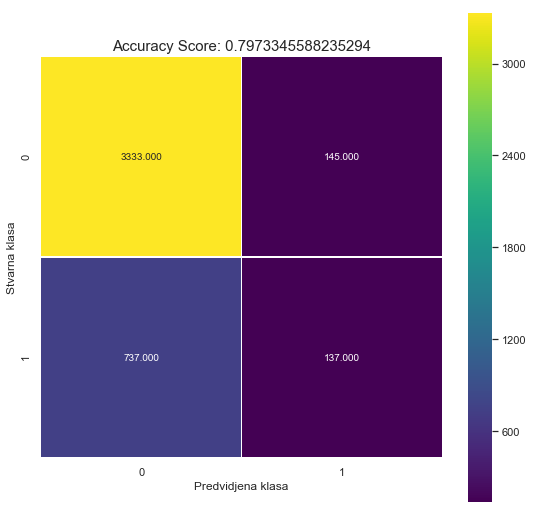

In [58]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_feature_selection_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      3478
           1       0.49      0.16      0.24       874

   micro avg       0.80      0.80      0.80      4352
   macro avg       0.65      0.56      0.56      4352
weighted avg       0.75      0.80      0.75      4352



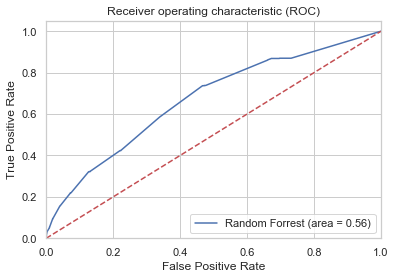

In [60]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_feature_selection_ROC.png'
plt.savefig(figname)
plt.show()

In [61]:
# izbor atributa i oversampling

In [62]:
X_resampled, y_resampled = SMOTE(kind="svm").fit_sample(X_transformed, y)

In [63]:
X_resampled[0]

array([0.000188  , 0.00003289, 0.00004993, 0.00000191, 0.00077435,
       0.00573086, 0.00022468, 0.00054967, 0.00003353, 0.0000149 ])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [65]:
X_train[0]

array([0.05392335, 0.12766352, 0.03599383, 0.00013481, 0.12132753,
       0.34066074, 0.05392335, 0.06740418, 0.04044251, 0.05392335])

In [66]:
X_test[0]

array([0.02053747, 0.06017478, 0.01369165, 0.00006846, 0.06161241,
       0.24069914, 0.02396038, 0.03765203, 0.02396038, 0.02738329])

In [67]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7836490528414756


In [68]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, np.ravel(y_train), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.780457841
standard deviation: 0.013764770


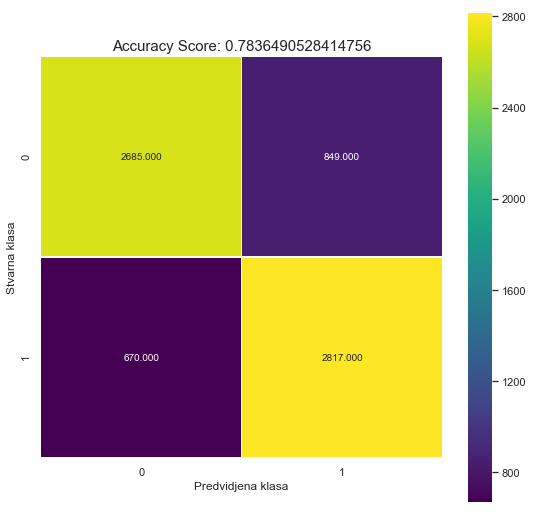

In [69]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_feature_selection_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3534
           1       0.77      0.81      0.79      3487

   micro avg       0.78      0.78      0.78      7021
   macro avg       0.78      0.78      0.78      7021
weighted avg       0.78      0.78      0.78      7021



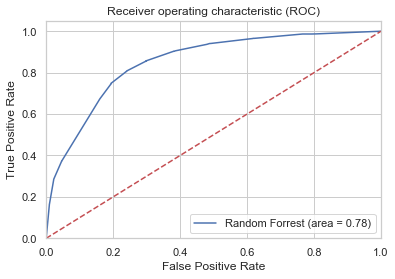

In [71]:
# The receiver operating characteristic (ROC) curve is 
# another common tool used with binary classifiers. 
# The dotted line represents the ROC curve of a purely 
# random classifier; a good classifier stays as far away 
# from that line as possible (toward the top-left corner)

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_feature_selection_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [72]:
 # clf.predict([15, 51391.5957050955, 34.5, 591.0033506085982, 208, 1773010.0518257946, 46, 162, 16, 24])

In [73]:
# new_object = np.array([60, 151, 22, 134, 214109.69314276046, 147.48611111111111, 4657346797.746469, 10526.068664273025, 728, 0.0067802994632262924, 258741488.7636927, 31578205.992819075, 259, 469, 36, 41, 211])

# new_object = np.array([15, 38, 0, 15, 51391.5957050955, 34.5, 61168846.787989914, 591.0033506085982, 208, 0.028985507246376812, 3398269.2659994396, 1773010.0518257946, 46, 162, 16, 24, 53])

# new_object = np.array([2, 6, 0, 2, 409.10624136968926, 4.0, 6545.699861915028, 0.545474988492919, 12, 0.25, 363.64999232861265, 1636.424965478757, 1, 11, 1, 8, 8])

In [74]:
# new_object = preprocessing.normalize(new_object.reshape(1,-1))
# print(new_object)

In [75]:
# ind

In [76]:
# i = np.arange(17)
    
# print(i)
#new_object = np.delete(new_object, !ind)
#print(new_object)

In [77]:
# new_object = np.delete(new_object, [0, 1, 2, 6, 9, 10, 16])
# print(new_object)

In [78]:
# new_object = new_object.reshape(1, -1)

In [79]:
# r = clf.predict(new_object)

In [80]:
# r

In [81]:
f = open("c_attributes.txt")

In [82]:
instances = f.readlines()

In [83]:
# instances

In [84]:
f.close()

In [85]:
predictions = []

In [86]:
for i in instances:
    i = i.strip('\n')
    i = i.strip('\[')
    i = i.strip('\]')
    #i = np.array(i)
    #i = np.fromstring(i)
    i = np.array(i.split(','), dtype=float)
    i = preprocessing.normalize(i.reshape(1,-1))
    print(i[0])
    i = np.delete(i, [0, 1, 2, 6, 9, 10, 16])
    # print(i)
    # print(clf.predict(i.reshape(1, -1)))
    #print(type(i))
    #print(clf.predict(i))
    
    predictions.append(clf.predict(i.reshape(1, -1))[0])

[0.00000001 0.00000002 0.00000001 0.00000001 0.00005257 0.00000006
 0.99843415 0.00000241 0.00000025 0.         0.05546856 0.00724487
 0.00000008 0.00000016 0.00000001 0.00000001 0.00000003]
[0.00000001 0.00000003 0.         0.00000001 0.00005908 0.00000018
 0.9984309  0.00000256 0.0000005  0.         0.05546838 0.00768024
 0.00000022 0.00000028 0.00000002 0.00000003 0.00000003]
[0.00000001 0.00000003 0.         0.00000001 0.00005444 0.00000006
 0.99843322 0.00000246 0.00000024 0.         0.05546851 0.0073724
 0.0000001  0.00000015 0.00000001 0.00000001 0.00000004]
[0.00000005 0.00000089 0.00000007 0.0000007  0.008737   0.00000025
 0.99407668 0.00003106 0.00000783 0.         0.05522648 0.09319469
 0.00000009 0.00000774 0.00000007 0.00000038 0.00000094]
[0.         0.00000001 0.         0.00000001 0.0000262  0.00000003
 0.9984473  0.0000017  0.00000012 0.         0.05546929 0.00511419
 0.00000003 0.00000009 0.         0.         0.00000001]
[0.00000632 0.00001422 0.         0.00000316 0

[0.00000014 0.00000118 0.00000007 0.00000061 0.00067089 0.00000138
 0.99812577 0.00000863 0.00000492 0.         0.05545143 0.02587733
 0.00000143 0.0000035  0.0000005  0.00000096 0.00000132]
[0.00000261 0.00000915 0.         0.00000261 0.00239635 0.00001333
 0.99726371 0.0000163  0.00003528 0.00000003 0.05540354 0.04888548
 0.00000784 0.00002744 0.00000327 0.00001111 0.00001176]
[0.00000017 0.00000046 0.         0.00000031 0.00024955 0.00000083
 0.99833594 0.00000526 0.00000237 0.         0.05546311 0.01578397
 0.0000006  0.00000177 0.0000001  0.00000029 0.00000063]
[0.0000001  0.00000062 0.         0.00000037 0.00049595 0.00000093
 0.99821305 0.00000742 0.00000353 0.         0.05545628 0.02224994
 0.00000098 0.00000256 0.00000023 0.00000044 0.00000073]
[0.00000005 0.00000075 0.         0.00000031 0.00036919 0.00000135
 0.99827628 0.0000064  0.00000372 0.         0.05545979 0.01919762
 0.00000101 0.0000027  0.00000023 0.00000062 0.00000081]
[0.00000005 0.00000072 0.         0.0000003  

[0.00000005 0.00000028 0.00000004 0.00000014 0.00018695 0.00000043
 0.99836715 0.00000455 0.00000139 0.         0.05546484 0.01366187
 0.00000045 0.00000095 0.00000008 0.00000015 0.00000032]
[0.00000001 0.00000025 0.         0.00000012 0.00013819 0.00000051
 0.99839147 0.00000392 0.00000132 0.         0.05546619 0.01174578
 0.00000041 0.00000092 0.00000006 0.00000015 0.00000026]
[0.00000026 0.00000168 0.         0.00000062 0.00064673 0.00000347
 0.99813783 0.00000847 0.00000838 0.         0.0554521  0.02540714
 0.00000221 0.00000617 0.00000062 0.00000194 0.00000194]
[0.00000025 0.00000159 0.         0.00000059 0.00070976 0.00000314
 0.99810637 0.00000887 0.00000821 0.         0.05545035 0.02661617
 0.00000209 0.00000612 0.00000067 0.00000201 0.00000184]
[0.0000002  0.00000143 0.         0.00000068 0.00047519 0.00000313
 0.99822341 0.00000726 0.00000682 0.         0.05545686 0.02177942
 0.0000017  0.00000511 0.00000041 0.0000015  0.00000164]
[0.00000009 0.00000097 0.         0.00000043 

[0.00000007 0.0000007  0.         0.00000036 0.00021697 0.00000153
 0.99835218 0.00000491 0.00000312 0.         0.05546401 0.01471772
 0.00000084 0.00000228 0.00000014 0.0000005  0.00000077]
[0.00000003 0.00000041 0.         0.00000022 0.00012372 0.0000009
 0.99839868 0.0000037  0.00000176 0.         0.05546659 0.0111139
 0.00000049 0.00000127 0.00000006 0.00000022 0.00000044]
[0.00000003 0.00000103 0.00000013 0.00000033 0.00039299 0.00000126
 0.9982644  0.0000066  0.00000368 0.         0.05545913 0.01980683
 0.00000105 0.00000263 0.00000025 0.0000006  0.00000105]
[0.00000007 0.00000048 0.         0.0000003  0.00043102 0.00000068
 0.99824544 0.00000691 0.00000277 0.         0.05545808 0.02074276
 0.00000078 0.00000199 0.00000017 0.0000003  0.00000055]
[0.00000016 0.00000085 0.         0.00000049 0.00059524 0.00000133
 0.99816351 0.00000813 0.00000473 0.         0.05545353 0.02437518
 0.00000127 0.00000345 0.00000033 0.00000068 0.00000101]
[0.00000043 0.00000229 0.         0.000001   0.

[0.00000001 0.00000002 0.         0.00000001 0.00004221 0.00000002
 0.99843931 0.00000216 0.00000013 0.         0.05546885 0.00649148
 0.00000004 0.00000009 0.00000001 0.00000001 0.00000002]
[0.00000001 0.00000003 0.         0.00000001 0.00004975 0.00000014
 0.99843555 0.00000235 0.0000004  0.         0.05546864 0.00704778
 0.00000017 0.00000023 0.00000001 0.00000002 0.00000003]
[0.00000001 0.00000003 0.         0.00000001 0.00003169 0.00000006
 0.99844456 0.00000188 0.00000019 0.         0.05546914 0.00562504
 0.00000007 0.00000012 0.00000001 0.00000001 0.00000004]
[0.         0.00000001 0.         0.         0.00001714 0.00000003
 0.99845181 0.00000138 0.00000009 0.         0.05546955 0.00413642
 0.00000003 0.00000006 0.         0.         0.00000002]
[0.00000015 0.00000073 0.         0.00000012 0.00035289 0.00000081
 0.99828441 0.00000626 0.00000277 0.         0.05546024 0.01876915
 0.00000056 0.00000221 0.00000012 0.00000035 0.00000088]
[0.00000041 0.00000235 0.         0.00000028 

[0.00000013 0.00000061 0.         0.00000014 0.00031834 0.00000072
 0.99830164 0.00000594 0.00000244 0.         0.0554612  0.01782681
 0.00000054 0.0000019  0.00000012 0.00000031 0.00000074]
[0.00000005 0.00000053 0.00000008 0.00000026 0.00025888 0.00000078
 0.99833129 0.00000536 0.0000023  0.         0.05546285 0.01607619
 0.00000068 0.00000163 0.00000013 0.00000029 0.00000058]
[0.00000014 0.00000103 0.00000017 0.00000046 0.00041766 0.0000014
 0.9982521  0.00000681 0.00000406 0.         0.05545845 0.02041879
 0.00000114 0.00000292 0.00000026 0.00000063 0.00000117]
[0.00000015 0.00000083 0.         0.00000046 0.00043935 0.00000146
 0.99824128 0.00000698 0.00000427 0.         0.05545785 0.02094212
 0.0000012  0.00000307 0.00000028 0.00000068 0.00000098]
[0.00000005 0.00000053 0.00000008 0.00000026 0.00025888 0.00000078
 0.99833129 0.00000536 0.0000023  0.         0.05546285 0.01607619
 0.00000068 0.00000163 0.00000013 0.00000029 0.00000058]
[0.00000002 0.00000013 0.         0.00000006 0

[0.00000001 0.00000004 0.00000002 0.00000001 0.00003786 0.00000012
 0.99844148 0.00000205 0.00000032 0.         0.05546897 0.00614804
 0.00000013 0.00000018 0.00000001 0.00000002 0.00000005]
[0.         0.00000001 0.         0.00000001 0.00002215 0.00000011
 0.99844931 0.00000157 0.00000023 0.         0.05546941 0.00470284
 0.0000001  0.00000013 0.00000001 0.00000002 0.00000001]
[0.         0.00000002 0.         0.00000001 0.00004544 0.00000011
 0.9984377  0.00000225 0.00000032 0.         0.05546876 0.00673549
 0.00000013 0.00000019 0.00000001 0.00000002 0.00000002]
[0.00000058 0.00001036 0.0000023  0.00000403 0.00198794 0.00001289
 0.99746796 0.00001484 0.00003223 0.00000003 0.05541489 0.04452982
 0.00000921 0.00002302 0.00000288 0.00000806 0.00001094]
[0.         0.00000002 0.         0.00000001 0.0000407  0.00000008
 0.99844007 0.00000212 0.00000026 0.         0.05546889 0.00637445
 0.0000001  0.00000016 0.00000001 0.00000002 0.00000002]
[0.         0.00000002 0.00000001 0.00000001 

[0.         0.00000002 0.         0.00000001 0.00003994 0.00000009
 0.99844045 0.0000021  0.00000028 0.         0.05546891 0.00631454
 0.00000011 0.00000016 0.00000001 0.00000002 0.00000002]
[0.         0.00000002 0.         0.00000001 0.00003151 0.00000012
 0.99844465 0.00000187 0.00000028 0.         0.05546915 0.00560924
 0.00000012 0.00000016 0.00000001 0.00000002 0.00000002]
[0.         0.00000005 0.00000003 0.00000001 0.00004732 0.0000001
 0.99843677 0.00000229 0.00000031 0.         0.05546871 0.0068733
 0.00000013 0.00000018 0.00000001 0.00000002 0.00000005]
[0.         0.00000002 0.         0.00000001 0.00002315 0.00000012
 0.99844882 0.0000016  0.00000024 0.         0.05546938 0.00480735
 0.0000001  0.00000014 0.00000001 0.00000002 0.00000002]
[0.         0.00000001 0.         0.00000001 0.00002191 0.00000011
 0.99844943 0.00000156 0.00000022 0.         0.05546941 0.00467742
 0.00000009 0.00000013 0.00000001 0.00000002 0.00000001]
[0.         0.00000001 0.         0.00000001 0.

[0.         0.00000001 0.         0.         0.00002586 0.
 0.99844746 0.00000169 0.00000004 0.         0.0554693  0.00508137
 0.00000001 0.00000003 0.         0.         0.00000001]
[0.00000033 0.00000127 0.         0.00000057 0.00072305 0.00000152
 0.99809975 0.00000895 0.00000549 0.         0.05544999 0.02686397
 0.00000172 0.00000377 0.00000053 0.00000094 0.0000016 ]
[0.00000057 0.00000263 0.         0.00000149 0.00136869 0.00000309
 0.99777741 0.00001232 0.00001156 0.         0.05543208 0.03695472
 0.00000309 0.00000847 0.00000103 0.00000206 0.0000032 ]
[0.         0.00000001 0.         0.00000001 0.00004039 0.00000002
 0.99844022 0.00000212 0.00000012 0.         0.0554689  0.00635001
 0.00000005 0.00000007 0.         0.         0.00000001]
[0.         0.00000001 0.         0.         0.00002241 0.
 0.99844918 0.00000158 0.00000003 0.         0.0554694  0.00472978
 0.00000001 0.00000003 0.         0.         0.00000001]
[0.         0.00000001 0.         0.         0.00002251 0.
 0

[0.0000012  0.00000554 0.         0.00000193 0.00137718 0.00000649
 0.99777317 0.00001236 0.00001783 0.00000001 0.05543184 0.03706897
 0.00000458 0.00001325 0.00000145 0.0000041  0.00000675]
[0.         0.00000002 0.         0.00000001 0.00003995 0.
 0.99844044 0.00000211 0.00000005 0.         0.05546891 0.00631602
 0.00000001 0.00000004 0.         0.         0.00000002]
[0.00000109 0.00000381 0.         0.00000181 0.00136869 0.00000489
 0.99777741 0.00001232 0.00001504 0.00000001 0.05543208 0.03695472
 0.00000381 0.00001123 0.00000127 0.00000326 0.00000489]
[0.         0.00000001 0.         0.00000001 0.00003778 0.00000018
 0.99844152 0.00000205 0.00000041 0.         0.05546897 0.00614189
 0.00000017 0.00000024 0.00000001 0.00000002 0.00000002]
[0.00000166 0.00000533 0.00000033 0.000002   0.00173194 0.00000799
 0.99759592 0.00001386 0.00002231 0.00000001 0.055422   0.0415665
 0.00000533 0.00001698 0.000002   0.00000599 0.00000699]
[0.         0.00000002 0.         0.00000002 0.0000490

[0.         0.00000002 0.         0.00000001 0.00001803 0.00000004
 0.99845137 0.00000141 0.00000011 0.         0.05546952 0.00424303
 0.00000004 0.00000007 0.         0.00000001 0.00000002]
[0.         0.00000002 0.         0.00000001 0.00003351 0.00000003
 0.99844365 0.00000193 0.00000014 0.         0.05546909 0.00578421
 0.00000005 0.00000009 0.00000001 0.00000001 0.00000003]
[0.         0.00000002 0.         0.00000001 0.00001803 0.00000004
 0.99845137 0.00000141 0.00000011 0.         0.05546952 0.00424303
 0.00000004 0.00000007 0.         0.00000001 0.00000002]
[0.00000001 0.00000003 0.         0.00000001 0.00003802 0.00000009
 0.9984414  0.00000205 0.00000026 0.         0.05546897 0.00616098
 0.0000001  0.00000016 0.00000001 0.00000002 0.00000003]
[0.         0.00000002 0.         0.00000001 0.00003401 0.00000003
 0.9984434  0.00000194 0.00000014 0.         0.05546908 0.00582705
 0.00000005 0.00000009 0.00000001 0.00000001 0.00000003]
[0.00000299 0.00001195 0.00000199 0.00000598 

[0.00000004 0.00000027 0.         0.00000013 0.00044493 0.00000058
 0.9982385  0.00000702 0.00000248 0.         0.05545769 0.0210747
 0.0000006  0.00000188 0.00000018 0.00000035 0.00000031]
[0.0000004  0.00000105 0.00000018 0.00000054 0.00052151 0.00000159
 0.9982003  0.00000761 0.00000478 0.         0.05545557 0.02281601
 0.00000127 0.00000352 0.00000036 0.00000091 0.00000145]
[0.         0.         0.         0.         0.00002919 0.
 0.9984458  0.0000018  0.00000003 0.         0.05546921 0.00539854
 0.00000001 0.00000002 0.         0.         0.        ]
[0.00000016 0.00000081 0.00000008 0.00000038 0.00067089 0.00000104
 0.99812577 0.00000863 0.00000427 0.         0.05545143 0.02587733
 0.00000122 0.00000306 0.00000038 0.00000065 0.00000097]
[0.00000049 0.00000148 0.00000025 0.00000082 0.00077971 0.00000294
 0.99807147 0.0000093  0.0000083  0.         0.05544841 0.02789641
 0.0000023  0.000006   0.00000074 0.00000189 0.00000197]
[0.00000011 0.00000042 0.00000003 0.00000024 0.0003090

[0.00000484 0.00001453 0.         0.00000388 0.01262799 0.00000859
 0.99210601 0.00003731 0.00006201 0.00000011 0.055117   0.11192991
 0.0000126  0.00004942 0.00001066 0.00001453 0.00001938]
[0.00000778 0.00002138 0.         0.00000778 0.01139615 0.00001814
 0.99273112 0.00003545 0.00009136 0.00000021 0.05515173 0.10636405
 0.00001361 0.00007775 0.00001166 0.0000311  0.00002916]
[0.00000504 0.00001849 0.00000504 0.00000336 0.01089805 0.00000802
 0.99298357 0.00003468 0.00005548 0.00000009 0.05516575 0.10402685
 0.00001177 0.00004371 0.00000925 0.00001261 0.00002354]
[0.00000778 0.00002138 0.         0.00000778 0.01139615 0.00001814
 0.99273112 0.00003545 0.00009136 0.00000021 0.05515173 0.10636405
 0.00001361 0.00007775 0.00001166 0.0000311  0.00002916]
[0.00000797 0.00003188 0.         0.00001063 0.01485838 0.00002169
 0.99097126 0.00004045 0.00011688 0.00000033 0.05505396 0.12134342
 0.00001859 0.00009829 0.00001594 0.00003719 0.00003985]
[0.00000108 0.00000476 0.00000169 0.00000123 

[0.         0.00000001 0.         0.         0.00000964 0.00000001
 0.99845555 0.00000103 0.00000005 0.         0.05546975 0.00310294
 0.00000002 0.00000003 0.         0.         0.00000001]
[0.         0.00000001 0.         0.00000001 0.00001399 0.00000003
 0.99845338 0.00000125 0.00000008 0.         0.05546963 0.00373743
 0.00000003 0.00000005 0.         0.         0.00000001]


In [87]:
# [0.00045302, 0.0000755 , 0.00052852, 0.00218959, 0.00183246, 0.00176149, 
#  0.99748456, 0.00001435, 0.00792782, 0.00000302, 0.05541547, 0.04274908, 
#  0.00264261, 0.00528521, 0.00135906, 0.00181207, 0.00339764]

In [88]:
predictions[240:260]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [89]:
f = open("c_attributes_classes.txt")
classes = f.readlines()
f.close()

In [90]:
class_labels = []
for c in classes:
    class_labels.append(int(c.strip()))

In [91]:
class_labels[0]

0

In [92]:
class_labels[240:260]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [93]:
accuracy_score = metrics.accuracy_score(class_labels, predictions)

In [94]:
accuracy_score

0.34851138353765326

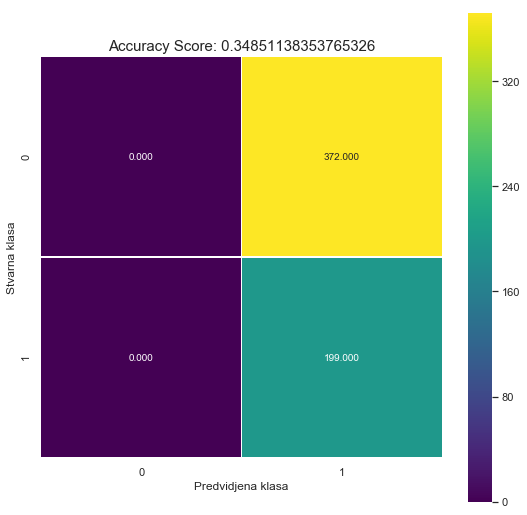

In [95]:
cm = metrics.confusion_matrix(class_labels, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(class_labels, predictions))
plt.title(all_sample_title, size = 15);
figname = 'RF_c_files_confussion_matrix.png'
#plt.savefig(figname)
plt.show()

In [96]:
# type(class_labels)

In [97]:
from collections import Counter

In [98]:
Counter(class_labels)

Counter({0: 372, 1: 199})

In [99]:
Counter(predictions)

Counter({1: 571})

In [100]:
data = np.empty(shape=(len(instances), 17), dtype=float)

In [101]:
data.shape

(571, 17)

In [102]:
instances[0].strip('\n')

'[19, 48, 13, 29, 130145.77451223352, 137.8125, 2471765661.417352, 5978.571516655727, 610, 0.0072562358276643995, 137320314.52318624, 17935714.54996718, 210, 400, 16, 21, 67]'

In [103]:
#####
j = 0
for i in instances:
    i = i.strip('\n')
    i = i.strip('\[')
    i = i.strip('\]')
    #i = np.array(i)
    #i = np.fromstring(i)
    i = np.array(i.split(','), dtype=float)
    i = preprocessing.normalize(i.reshape(1,-1))
    # print(type(i))
    # print(i)
    if j < data.shape[0]:
        data[j] = i
        j += 1

In [104]:
data

array([[0.00000001, 0.00000002, 0.00000001, ..., 0.00000001, 0.00000001,
        0.00000003],
       [0.00000001, 0.00000003, 0.        , ..., 0.00000002, 0.00000003,
        0.00000003],
       [0.00000001, 0.00000003, 0.        , ..., 0.00000001, 0.00000001,
        0.00000004],
       ...,
       [0.        , 0.00000001, 0.        , ..., 0.        , 0.        ,
        0.00000002],
       [0.        , 0.00000001, 0.        , ..., 0.        , 0.        ,
        0.00000001],
       [0.        , 0.00000001, 0.        , ..., 0.        , 0.        ,
        0.00000001]])

In [105]:
type(data)

numpy.ndarray

In [106]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data, class_labels, test_size=0.4, random_state=42)

In [107]:
X_train2.shape

(342, 17)

In [108]:
clf2 = RandomForestClassifier(n_jobs=2, random_state=0)
clf2.fit(X_train2, np.ravel(y_train2))
y_pred2 = clf2.predict(X_test2)
print(metrics.accuracy_score(y_test2, y_pred2))

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5982532751091703


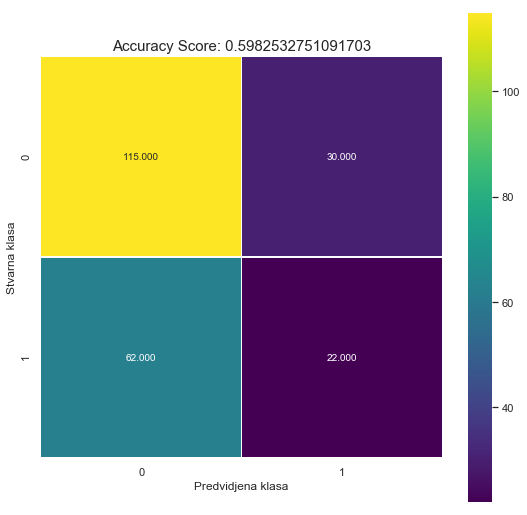

In [109]:
cm = metrics.confusion_matrix(y_test2, y_pred2)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test2, y_pred2))
plt.title(all_sample_title, size = 15);
figname = 'new_data_confussion_matrix.png'
#plt.savefig(figname)
plt.show()

In [110]:
y_pred3 = clf2.predict(X_train2)

In [111]:
cm = metrics.confusion_matrix(y_train2, y_pred3)

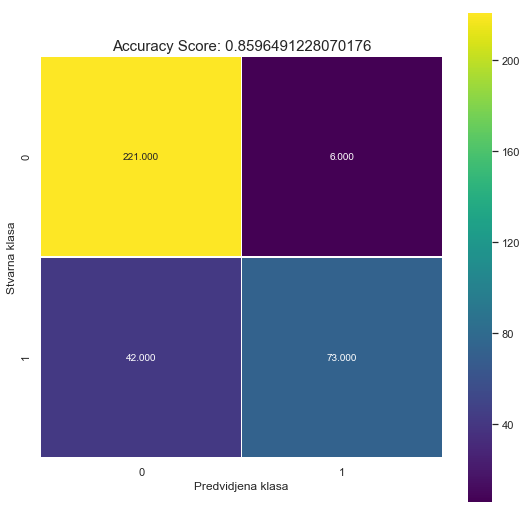

In [112]:
cm = metrics.confusion_matrix(y_train2, y_pred3)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_train2, y_pred3))
plt.title(all_sample_title, size = 15);
figname = 'new_data_confussion_matrix.png'
#plt.savefig(figname)
plt.show()

In [113]:
indices_zeroes = []
indices_ones = []

In [114]:
for val in enumerate(class_labels):
    if val[1] == 0:
        indices_zeroes.append(val[0])
    else:
        indices_ones.append(val[0])
    # print(val[0])

In [115]:
len(indices_ones)

199

In [116]:
len(indices_zeroes)

372

In [117]:
indices_ones

[31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 49,
 50,
 51,
 62,
 63,
 66,
 69,
 74,
 75,
 83,
 86,
 87,
 88,
 89,
 93,
 95,
 98,
 101,
 102,
 110,
 111,
 112,
 117,
 121,
 123,
 124,
 125,
 126,
 130,
 131,
 132,
 136,
 141,
 144,
 145,
 146,
 150,
 151,
 152,
 160,
 161,
 162,
 163,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 180,
 181,
 185,
 187,
 188,
 190,
 191,
 194,
 195,
 196,
 198,
 199,
 200,
 204,
 206,
 208,
 212,
 218,
 219,
 230,
 231,
 253,
 258,
 260,
 264,
 268,
 270,
 277,
 288,
 289,
 291,
 304,
 308,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 329,
 334,
 336,
 340,
 343,
 344,
 345,
 346,
 347,
 351,
 352,
 357,
 360,
 361,
 362,
 363,
 367,
 368,
 374,
 375,
 376,
 379,
 380,
 381,
 382,
 387,
 390,
 391,
 392,
 393,
 395,
 397,
 399,
 405,
 425,
 436,
 437,
 438,
 439,
 442,
 443,
 452,
 478,
 484,
 489,
 490,
 494,
 499,
 503,
 504,
 510,
 511,
 512,
 

In [118]:
np.average(data[indices_ones][:,11])

0.020985602058173153

In [119]:
np.average(data[indices_zeroes][:,11])

0.01882112823960489

In [120]:
np.average(data[indices_ones][:,8])

6.8281469804546446e-06

In [121]:
np.average(data[indices_zeroes][:,8])

5.930273005605808e-06

In [122]:
np.average(data[indices_ones][:,12])

1.5171999805835803e-06

In [123]:
np.average(data[indices_zeroes][:,12])

1.5020364297546552e-06

In [124]:
# github_instance = np.array([8, 353, 14, 140, 1948361.3189646779, 336.5, 220617335959.33817, 218541.19461053805, 2722, 0.0029717682020802376, 12256518664.407677, 655623583.8316141, 1346, 1376, 144, 72, 361], dtype=float)
# github_instance = np.array([5, 37, 8, 5, 1050957.9486631174, 55.52127659574467, 3239695746.7548647, 19450.175652740458, 933, 0.01801111324008431, 179983097.04193693, 58350526.95822137, 614, 319, 94, 17, 42])
# github_instance = np.array([11, 261, 18, 107, 2031006.1313715037, 263.83941605839414, 141380850105.87363, 178619.82390402522, 2504, 0.0037901842527527253, 7854491672.548534, 535859471.7120757, 1364, 1140, 137, 53, 272], dtype=float)
# -------------------------------------
# github_instance = np.array([49, 211, 2, 103, 476426.1581724572, 284.29411764705884, 38506260620.376114, 45148.38475387226, 1390, 0.0035174839644113386, 2139236701.1320064, 135445154.2616168, 537, 853, 51, 54, 260], dtype=float)
# -------------------------------------------
# github_instance = np.array([10, 70, 6, 32, 575623.6626825822, 77.9375, 3496484281.5796075, 14954.223070107917, 827, 0.012830793905372895, 194249126.75442263, 44862669.21032375, 430, 397, 80, 29, 80], dtype=float)
# -------------------------------------------
# github_instance = np.array([3, 23, 6, 13, 462080.56114427367, 58.5974025974026, 1586625502.3403487, 9025.573557934904, 659, 0.017065602836879433, 88145861.24113049, 27076720.67380471, 376, 283, 77, 24, 26], dtype=float)
# github_instance = np.array([3, 34, 6, 13, 64905.57020861779, 130.0, 1096904136.5256405, 2812.574709040104, 435, 0.007692307692307693, 60939118.69586892, 8437724.127120312, 182, 253, 14, 20, 37], dtype=float)


# isnum # github_instance = np.array([2, 17, 6, 5, 3029.874609116446, 29.4, 2618902.417135891, 29.69277116934117, 57, 0.034013605442176874, 145494.57872977172, 89078.31350802351, 14, 43, 5, 21, 19], dtype=float)
# isalpha

# strcmp
# github_instance = np.array([2, 14, 6, 3, 1454.4023793190904, 15.75, 360782.6902198419, 7.635612491425225, 33, 0.06349206349206349, 20043.482789991216, 22906.837474275675, 9, 24, 4, 14, 16], dtype=float)

# putchar
github_instance = np.array([2, 11, 6, 1, 24340.52014006465, 145.0, 511759435.9448593, 1176.4584734364582, 319, 0.006896551724137931, 28431079.774714407, 3529375.4203093746, 145, 174, 6, 12, 13], dtype=float)


In [125]:
github_instance

array([2.00000000e+00, 1.10000000e+01, 6.00000000e+00, 1.00000000e+00,
       2.43405201e+04, 1.45000000e+02, 5.11759436e+08, 1.17645847e+03,
       3.19000000e+02, 6.89655172e-03, 2.84310798e+07, 3.52937542e+06,
       1.45000000e+02, 1.74000000e+02, 6.00000000e+00, 1.20000000e+01,
       1.30000000e+01])

In [126]:
github_instance = preprocessing.normalize(github_instance.reshape(1,-1))

In [127]:
github_instance = np.delete(github_instance, [0, 1, 2, 6, 9, 10, 16])

In [128]:
github_instance

array([0.        , 0.00004749, 0.00000028, 0.0000023 , 0.00000062,
       0.00688577, 0.00000028, 0.00000034, 0.00000001, 0.00000002])

In [129]:
prediction = clf.predict(github_instance.reshape(1,-1))

In [130]:
prediction

array([1], dtype=int64)